In [1]:

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import matplotlib.pyplot as plt
import numpy as np

from qutip import mesolve

from src.modules.atom_config import RbAtom
from src.modules.ketbra_config import RbKetBras

In [2]:
#List the groundstates to be included in the simulation

atomStates = {
    "g1M":0, "g1":1, "g1P":2, # F=1,mF=-1,0,+1 respectively
    "g2MM":3, "g2M":4, "g2":5, "g2P":6, "g2PP":7 # F=2,mF=-2,..,+2 respectively
}



# List the excited levels to include in the simulation. the _d1 levels correspond to the D1 line levels, the other levels are by default the d2 levels
xlvls = [
'x0',
'x1M','x1','x1P',
'x2MM','x2M','x2','x2P','x2PP',
'x3MMM', 'x3MM','x3M','x3','x3P','x3PP', 'x3PPP',
'x1M_d1','x1_d1','x1P_d1',
'x2MM_d1','x2M_d1','x2_d1','x2P_d1','x2PP_d1'
]

#configure the atm state dictionary such that it includes the desired excited states, this includes the desired ground and excited states as arguments, 
# as well as a boolean for whether to include the photonic Hilbert space

kb_class=RbKetBras(atomStates, xlvls, False)

#precompute ketbras for speed
ketbras=kb_class.getrb_ketbras()
#print(ketbras)

In [3]:
#specify system b field groundstate splitting in MHz
bfieldsplit = '0'
#configure rb atom with desired CG coefficients and splittings
rb_atom = RbAtom(bfieldsplit, kb_class)

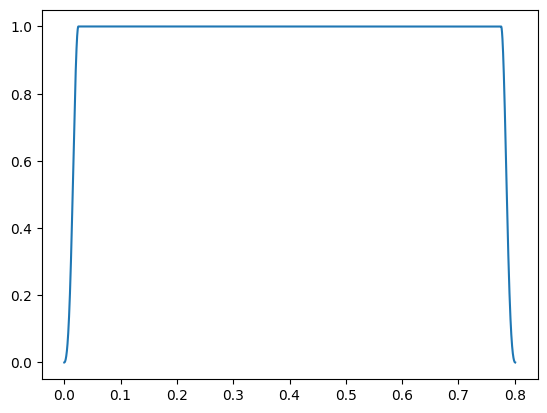

In [ ]:
from src.modules.laser_pulses import create_flattop_blackman


#Define the laser pulse parameters
two_phot_det=0.0
pulse_length=5/(2*np.pi)+0.005
#The pulse is a flattop pulse with a blackman window
pol_1="pi"
pulse_time=np.linspace(0,pulse_length,5000)
pulse_1=create_flattop_blackman(pulse_time, 1, 0.025, 0.025)
#what sign should this have??
det_1=(-500000*2*np.pi)
amp_1=1*np.sqrt(2*500000)*2*np.pi/rb_atom.CG_d1g2x1
#amp_1=2.0*np.sqrt(500000)*2*np.pi

pol_2="sigmaM"
pulse_2=create_flattop_blackman(pulse_time, 1, 0.025, 0.025)
plt.plot(pulse_time, pulse_2)
det_2=det_1-two_phot_det*2*np.pi-rb_atom.getrb_gs_splitting()

#det_2=-10000*2*np.pi
amp_2=1*np.sqrt(2*500000)*2*np.pi/rb_atom.CG_d1g1Px1
#amp_2=2.0*np.sqrt(500000)*2*np.pi

ham, args=rb_atom.gen_H_FarDetuned_Raman_PulsePair_D1(ketbras, atomStates, det_1, det_2,pol_1, pol_2, amp_1, amp_2,pulse_time, pulse_1, pulse_2)

In [5]:
#add decay ops
c_op_list=[]
c_op_list+=rb_atom.spont_em_ops_far_detuned(atomStates,pol_1,amp_1,det_1)
c_op_list+=rb_atom.spont_em_ops_far_detuned(atomStates,pol_2,amp_2,det_2)


In [6]:
psi0 = kb_class.get_ket_atomic('g2')
output_mesolve = mesolve(ham, psi0, pulse_time, c_op_list)

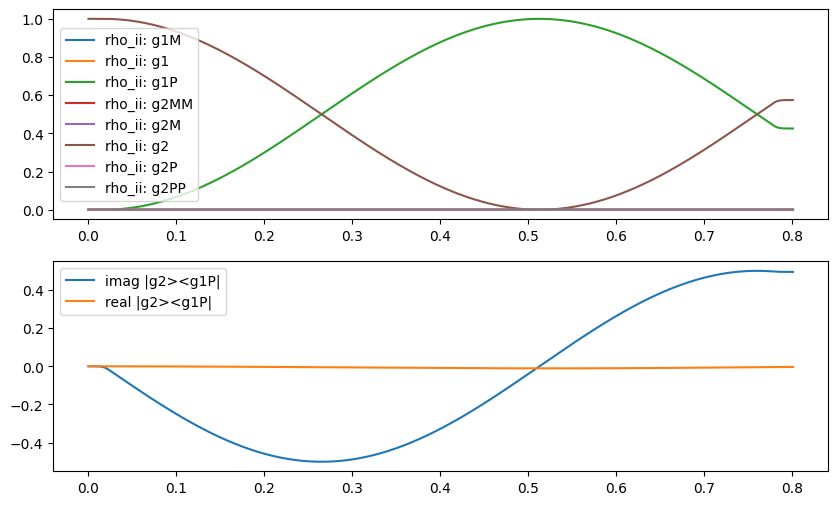

In [7]:
#for mesolve solver
fig, axes = plt.subplots(2, 1, figsize=(10,6))
state_labels = list(atomStates.keys())
for i in range(8):
    axes[0].plot(pulse_time, [np.real(output_mesolve.states[x][i, i]) for x in range(len(pulse_time))], label=f"rho_ii: {state_labels[i]}")

axes[1].plot(pulse_time, [np.imag(output_mesolve.states[x][2, 5]) for x in range(len(pulse_time))], label="imag |g2><g1P|")
axes[1].plot(pulse_time, [np.real(output_mesolve.states[x][2, 5]) for x in range(len(pulse_time))], label="real |g2><g1P|")

axes[0].legend()
axes[1].legend()

In [ ]:
# Spontaneous emission from D1 and D2 lines
sigma_spontDecayOp = sum([x.dag()*x for x in c_op_list])
exp_spontDecay = np.abs( np.array([(x*sigma_spontDecayOp).tr() for x in output_mesolve.states]) )
n_spont = np.trapezoid(exp_spontDecay, dx=pulse_time[1]-pulse_time[0])
print(f"Total Spontaneous Emission: {n_spont}")   


Total Spontaneous Emission: 1.2800926873037072e-09


/var/folders/yf/cmqhy1ks3k1g6q5y0rrg_91m0000gn/T/ipykernel_97037/305541595.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  n_spont = np.trapz(exp_spontDecay, dx=pulse_time[1]-pulse_time[0])
